In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

In [4]:
republican = pd.read_csv("LatinosForTrump.csv")
print(republican.shape)
republican.head(5)

(10000, 31)


,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,Love,...,Message,Link,Final Link,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Interaction Rate,Interaction Rate (weighted — Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )
0,Back The Blue New Jersey,NaN,308089070206895,774,2020-10-02 11:35:26 EDT,Status,127,7,202,56,...,This is from a police officer that worked a lo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.16,51.16
1,TUCSON FOR BIDEN,NaN,365959221096173,855,2020-10-17 22:49:42 EDT,Photo,215,59,2,100,...,Hubby putting Biden signs on Valencia across f...,https://www.facebook.com/photo.php?fbid=133363...,NaN,NaN,Photos from Elisa Jaimez's post,NaN,NaN,NaN,44.56,44.56
2,Nueces County for Trump,NaN,251232915270978,6,2020-09-19 08:33:00 EDT,Link,1,1,0,0,...,Join us TODAY for our weekly TRUMP TRAIN CARAV...,https://www.facebook.com/events/1230269340642425/,NaN,NaN,Trump Train Caravan,"Latinos for Trump, Coastal Bend Republicans, C...",NaN,NaN,33.33,33.33
3,Latinos For Trump-El Paso,NaN,314234929756039,173,2020-10-06 21:06:10 EDT,Photo,24,11,2,11,...,https://www.facebook.com/100001269879939/posts...,https://www.facebook.com/photo.php?fbid=355820...,NaN,NaN,Freddy,"I am a,\nMexican American Patriot \nWho unders...",NaN,NaN,27.75,27.75
4,MISION POSIBLE 2020,NaN,918054358526588,1225,2020-09-16 00:09:50 EDT,Link,122,32,124,42,...,Nota: No importa que los medios de desinformac...,https://trendingpolitics.com/watch-massive-lat...,NaN,NaN,"WATCH: Massive ""Latinos For Trump"" Car Parade ...","On Sunday, a massive 'Latinos for Trump' carav...",NaN,NaN,26.12,26.12


In [9]:
republican.columns

Index(['Group Name', 'User Name', 'Facebook Id', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Interaction Rate',
       'Interaction Rate (weighted  —  Likes 1x Shares 1x Comments 1x Love 1x Wow 1x Haha 1x Sad 1x Angry 1x Care 1x )',
       'clean_url'],
      dtype='object')

In [10]:
message = republican[['Message','Description']]
message

,Message,Description
0,This is from a police officer that worked a lo...,NaN
1,Hubby putting Biden signs on Valencia across f...,NaN
2,Join us TODAY for our weekly TRUMP TRAIN CARAV...,"Latinos for Trump, Coastal Bend Republicans, C..."
3,https://www.facebook.com/100001269879939/posts...,"I am a,\nMexican American Patriot \nWho unders..."
4,Nota: No importa que los medios de desinformac...,"On Sunday, a massive 'Latinos for Trump' carav..."
...,...,...
9995,NaN,Fox NewsTop VidsWhite House Live: President Tr...
9996,NaN,LIVE: President Donald Trump holds Latinos For...
9997,NaN,National Proud Boys chairman Enrique Tarrio is...
9998,NaN,@UnivisionNews encuesta de votantes latinos......


In [11]:
content = message['Message'].fillna('') + (' ' + message['Description']).fillna('')

content = pd.DataFrame(content)
content.columns = ['Message']
content

,Message
0,This is from a police officer that worked a lo...
1,Hubby putting Biden signs on Valencia across f...
2,Join us TODAY for our weekly TRUMP TRAIN CARAV...
3,https://www.facebook.com/100001269879939/posts...
4,Nota: No importa que los medios de desinformac...
...,...
9995,Fox NewsTop VidsWhite House Live: President T...
9996,LIVE: President Donald Trump holds Latinos Fo...
9997,National Proud Boys chairman Enrique Tarrio i...
9998,@UnivisionNews encuesta de votantes latinos.....


In [12]:
content['cleanMessage'] = content['Message'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage']

0       This is from a police officer that worked a lo...
1       Hubby putting Biden signs on Valencia across f...
2       Join us TODAY for our weekly TRUMP TRAIN CARAV...
3                                                        
4       Nota: No importa que los medios de desinformac...
                              ...                        
9995     Fox NewsTop VidsWhite House Live: President T...
9996     LIVE: President Donald Trump holds Latinos Fo...
9997     National Proud Boys chairman Enrique Tarrio i...
9998     @UnivisionNews encuesta de votantes latinos.....
9999     President Donald J. Trump hosts a "Latinos fo...
Name: cleanMessage, Length: 10000, dtype: object

In [13]:
# Convert to list
data = content.cleanMessage.tolist()

In [14]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

## Tokenize words and Clean-up text

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['this', 'is', 'from', 'police', 'officer', 'that', 'worked', 'local', 'trump', 'rally', 'friday', 'night', 'speaks', 'volumes', 'attended', 'the', 'president', 'rally', 'in', 'newport', 'news', 'yesterday', 'not', 'like', 'wanted', 'to', 'though', 'was', 'deployed', 'there', 'in', 'my', 'official', 'capacity', 'got', 'the', 'word', 'late', 'thursday', 'night', 'and', 'answered', 'the', 'call', 'exceptionally', 'thankful', 'for', 'this', 'experience', 'because', 'got', 'to', 'see', 'oil', 'and', 'water', 'side', 'by', 'side', 'literally', 'few', 'feet', 'apart', 'now', 'even', 'more', 'absolutely', 'certain', 'that', 'support', 'the', 'correct', 'side', 'like', 'to', 'tell', 'anyone', 'that', 'wants', 'to', 'hear', 'it', 'what', 'saw', 'the', 'first', 'half', 'of', 'the', 'assignment', 'was', 'overwhelmed', 'by', 'the', 'community', 'support', 'while', 'moving', 'to', 'our', 'staging', 'point', 'the', 'citizens', 'were', 'phenomenal', 'in', 'their', 'vocal', 'support', 'of', 'us', 'am

## Creating Bigram and Trigram Models

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['this', 'is', 'from', 'police_officer', 'that', 'worked_local', 'trump', 'rally', 'friday', 'night', 'speaks_volumes_attended', 'the', 'president', 'rally', 'in', 'newport', 'news', 'yesterday', 'not', 'like', 'wanted', 'to', 'though', 'was', 'deployed_there', 'in', 'my', 'official_capacity_got', 'the', 'word_late_thursday', 'night', 'and', 'answered', 'the', 'call_exceptionally_thankful', 'for', 'this', 'experience', 'because', 'got', 'to', 'see_oil', 'and', 'water_side', 'by', 'side_literally_few_feet', 'apart_now_even', 'more', 'absolutely_certain', 'that', 'support', 'the', 'correct_side', 'like', 'to', 'tell', 'anyone', 'that', 'wants', 'to', 'hear', 'it', 'what', 'saw', 'the', 'first_half', 'of', 'the', 'assignment', 'was', 'overwhelmed', 'by', 'the', 'community', 'support', 'while_moving', 'to', 'our', 'staging_point', 'the', 'citizens', 'were', 'phenomenal', 'in', 'their', 'vocal', 'support', 'of', 'us', 'american', 'flags', 'blue', 'line', 'flags', 'trump', 'flags', 'were', '

## Remove Stopwords, Make Bigrams and Lemmatize


In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#!python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['trump', 'rally', 'night', 'attend', 'yesterday', 'want', 'deploy', 'official_capacity', 'get', 'night', 'answer', 'call_exceptionally', 'thankful', 'experience', 'get', 'even', 'support', 'correct_side', 'tell', 'want', 'see', 'first', 'half', 'assignment', 'overwhelmed', 'community', 'support', 'move', 'citizen', 'phenomenal', 'vocal', 'support', 'american', 'flag', 'blue', 'line', 'flag', 'trump', 'flag', 'waive', 'people', 'thank', 'pray', 'let', 'know', 'much', 'silent_majority', 'support', 'hear', 'election', 'medium', 'left', 'would', 'report_saw', 'thousand', 'latinos', 'white', 'respectful', 'conduct', 'say', 'love', 'pray', 'would', 'think', 'event', 'parade', 'honor', 'lie', 'listen', 'medium', 'garbage', 'something_real', 'happen', 'long', 'support', 'protect', 'stand', 'pass', 'rally', 'participant', 'group', 'absorbed_lot', 'last_month', 'last', 'night', 'exceptionally_evil', 'listen', 'blm', 'tell', 'mother', 'abort', 'call', 'even', 'saw_guy', 'dressed', 'realize', 'p

## Bag of Words

In [19]:
from collections import Counter
flat_list_words = [item for sublist in data_words_nostops for item in sublist]
count_words = Counter(flat_list_words)
count_words.most_common(500)

[('trump', 20616),
 ('latinos', 9831),
 ('president', 6172),
 ('de', 3909),
 ('florida', 3830),
 ('biden', 3713),
 ('us', 3709),
 ('donald', 2985),
 ('support', 2815),
 ('people', 2726),
 ('la', 2428),
 ('vote', 2296),
 ('que', 2191),
 ('like', 2116),
 ('el', 2068),
 ('american', 2053),
 ('america', 1909),
 ('en', 1875),
 ('joe', 1775),
 ('group', 1635),
 ('rally', 1587),
 ('know', 1582),
 ('roundtable', 1548),
 ('latino', 1520),
 ('miami', 1511),
 ('news', 1473),
 ('caravan', 1440),
 ('night', 1405),
 ('south', 1361),
 ('los', 1357),
 ('get', 1311),
 ('one', 1303),
 ('would', 1299),
 ('state', 1290),
 ('anti', 1283),
 ('socialism', 1274),
 ('many', 1262),
 ('flags', 1258),
 ('live', 1254),
 ('voters', 1194),
 ('media', 1176),
 ('black', 1140),
 ('time', 1133),
 ('election', 1125),
 ('event', 1112),
 ('make', 1110),
 ('even', 1109),
 ('first', 1107),
 ('great', 1105),
 ('thousands', 1101),
 ('harris', 1094),
 ('said', 1068),
 ('love', 1066),
 ('americans', 1057),
 ('las', 1057),
 ('wom

## Create the Dictionary and Corpus needed for Topic Modeling

In [20]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 3), (38, 1), (39, 3), (40, 1), (41, 1), (42, 4), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 4), (70, 2), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 3), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 6), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 4), (91, 1), (92, 1), (93, 3), (94, 1), (95, 4), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (110, 1)

[[('abort', 1),
  ('absorbed_lot', 1),
  ('american', 1),
  ('answer', 1),
  ('ass', 1),
  ('assignment', 1),
  ('attend', 1),
  ('back', 2),
  ('beat', 1),
  ('believe', 1),
  ('bite', 1),
  ('blm', 2),
  ('blue', 2),
  ('call', 1),
  ('call_exceptionally', 1),
  ('child', 1),
  ('citizen', 1),
  ('clothe', 1),
  ('color', 1),
  ('community', 1),
  ('conduct', 1),
  ('continue_thanke', 1),
  ('correct_side', 1),
  ('could', 2),
  ('cowards_disperse', 1),
  ('democratic', 1),
  ('deploy', 1),
  ('deserve', 1),
  ('dressed', 1),
  ('election', 1),
  ('end', 1),
  ('even', 2),
  ('event', 1),
  ('evil', 1),
  ('exceptionally_evil', 1),
  ('experience', 1),
  ('first', 1),
  ('flag', 3),
  ('foul_mouthe', 1),
  ('garbage', 3),
  ('garbage_yelle', 1),
  ('gear_matche', 1),
  ('get', 4),
  ('go', 1),
  ('great', 1),
  ('group', 2),
  ('half', 1),
  ('happen', 1),
  ('hate', 1),
  ('hear', 1),
  ('hesitate', 1),
  ('hold', 1),
  ('honor', 1),
  ('honorable', 2),
  ('hook', 1),
  ('human', 1)

## Building the Topic Model

In [21]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [22]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.504*"trump" + 0.169*"latinos" + 0.107*"roundtable" + 0.050*"host" + '
  '0.016*"put" + 0.016*"include" + 0.015*"stop" + 0.014*"supporter" + '
  '0.010*"pay" + 0.010*"sign"'),
 (1,
  '0.204*"latinosfortrump" + 0.122*"true" + 0.108*"hard" + 0.073*"thank" + '
  '0.067*"guy" + 0.045*"son" + 0.041*"message" + 0.026*"tweet" + '
  '0.025*"success" + 0.015*"thrive"'),
 (2,
  '0.112*"country" + 0.082*"election" + 0.067*"day" + 0.042*"participate" + '
  '0.041*"help" + 0.040*"rally" + 0.036*"big" + 0.035*"bring" + 0.034*"car" + '
  '0.031*"join"'),
 (3,
  '0.350*"event" + 0.234*"biden" + 0.077*"photo" + 0.048*"lie" + 0.036*"hat" + '
  '0.033*"tag" + 0.020*"dumb" + 0.011*"finger" + 0.000*"orlando" + '
  '0.000*"emblazon"'),
 (4,
  '0.158*"voter" + 0.092*"hispanic" + 0.083*"campaign" + 0.082*"biden" + '
  '0.072*"poll" + 0.063*"percent" + 0.048*"election" + 0.043*"accord" + '
  '0.043*"win" + 0.040*"democratic"'),
 (5,
  '0.175*"new" + 0.074*"one" + 0.071*"national" + 0.067*"call" + 0.05

## Compute Model Perplexity and Coherence Score


In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -13.764346397523457

Coherence Score:  0.3507542587616014


## Visualize the topics-keywords

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.285116  0.054811       1        1  18.892265
11     0.248696  0.048466       2        1  15.384735
0      0.092172 -0.282374       3        1  12.563785
14     0.217063  0.129403       4        1   9.830981
16     0.203439  0.168772       5        1   6.918437
2      0.086457 -0.039268       6        1   5.891821
4      0.045382 -0.021915       7        1   4.676771
19     0.106722  0.092382       8        1   4.370887
12     0.013177 -0.287911       9        1   3.771561
8      0.005055 -0.201384      10        1   3.048361
7     -0.037447 -0.068824      11        1   3.019137
13    -0.050855 -0.008685      12        1   2.796619
5     -0.088111  0.006600      13        1   1.736515
9     -0.122329  0.040805      14        1   1.569521
3     -0.136003  0.039600      15        1   1.249791
17    -0.106111  0.069072      16        1   1.217231
1     -0.175070  0.045466      17        1   1.069699
15    -0.177564  0.039131      18        1   1.012304
18    -0.171573  0.110033      19        1   0.961271
6     -0.238217  0.065821      20        1   0.018302, topic_info=          Term          Freq         Total Category  logprob  loglift
128      trump  16565.000000  16565.000000  Default  30.0000  30.0000
145       time   3037.000000   3037.000000  Default  29.0000  29.0000
64     latinos   6109.000000   6109.000000  Default  28.0000  28.0000
200       vote   5085.000000   5085.000000  Default  27.0000  27.0000
44       great   3136.000000   3136.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
3157  horrible      0.005046      1.347086  Topic20  -9.1504   3.0189
3156     filth      0.005046      1.347051  Topic20  -9.1504   3.0189
3154    decent      0.005046      1.347062  Topic20  -9.1504   3.0189
3147      vila      0.005046      1.347051  Topic20  -9.1504   3.0189
3153     charm      0.005046      1.347051  Topic20  -9.1504   3.0189

[829 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
147      12  0.994563       able
643      13  0.983159   abortion
312       7  0.998412     accord
412       2  0.995438        add
413      11  0.907020      admit
...     ...       ...        ...
137      13  0.385426  yesterday
599       9  0.995896        yet
138       1  0.471486      young
138       5  0.527486      young
455      16  0.901161       zoom

[593 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 1, 15, 17, 3, 5, 20, 13, 9, 8, 14, 6, 10, 4, 18, 2, 16, 19, 7])

## Building LDA Mallet Model

In [25]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(5,
  [('news', 0.031167779801659582),
   ('campaign', 0.02995345071847804),
   ('medium', 0.020643594414086218),
   ('call', 0.02044120623355596),
   ('president', 0.019328071240639545),
   ('note', 0.015887472171625176),
   ('member', 0.013560008095527222),
   ('police', 0.011940902651285164),
   ('supporter', 0.01163732038048978),
   ('attack', 0.011232544019429266)]),
 (13,
  [('trump', 0.08517118252467969),
   ('people', 0.04715395925225793),
   ('day', 0.04095778197857593),
   ('election', 0.033816425120772944),
   ('country', 0.02194917034236505),
   ('black', 0.021109010712035286),
   ('regime', 0.021109010712035286),
   ('back', 0.019953791220331862),
   ('protest', 0.01890359168241966),
   ('stand', 0.017118252467968914)]),
 (15,
  [('vote', 0.06176239181746656),
   ('latino', 0.0529110936270653),
   ('biden', 0.04533831628638867),
   ('percent', 0.03747049567269866),
   ('trump', 0.03609362706530291),
   ('voter', 0.03324154209284028),
   ('year', 0.02065302911093627),
   (

## Finding the optimal number of topics for LDA

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

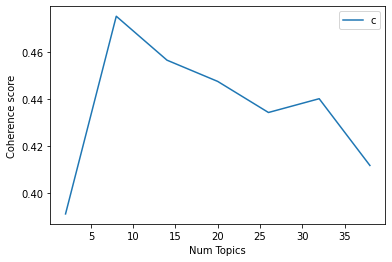

In [29]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3912
Num Topics = 8  has Coherence Value of 0.4753
Num Topics = 14  has Coherence Value of 0.4566
Num Topics = 20  has Coherence Value of 0.4476
Num Topics = 26  has Coherence Value of 0.4344
Num Topics = 32  has Coherence Value of 0.4402
Num Topics = 38  has Coherence Value of 0.4118


In [31]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.082*"roundtable" + 0.064*"live" + 0.054*"watch" + 0.051*"text" + '
  '0.049*"today" + 0.045*"hold" + 0.045*"thousand" + 0.036*"host" + '
  '0.034*"latinosfortrump" + 0.033*"cars_participate"'),
 (1,
  '0.123*"trump" + 0.066*"great" + 0.056*"make" + 0.056*"time" + '
  '0.046*"president" + 0.045*"american" + 0.035*"woman" + 0.033*"love" + '
  '0.031*"world" + 0.022*"man"'),
 (2,
  '0.081*"trump" + 0.023*"day" + 0.016*"candidate" + 0.015*"join" + '
  '0.014*"show" + 0.014*"election" + 0.012*"country" + 0.012*"news" + '
  '0.012*"supporter" + 0.012*"train"'),
 (3,
  '0.061*"vote" + 0.043*"voter" + 0.033*"biden" + 0.027*"latino" + '
  '0.025*"state" + 0.020*"election" + 0.019*"campaign" + 0.016*"hispanic" + '
  '0.014*"white" + 0.014*"democratic"'),
 (4,
  '0.010*"community" + 0.009*"people" + 0.009*"leader" + 0.008*"year" + '
  '0.008*"call" + 0.007*"black" + 0.006*"immigrant" + 0.006*"political" + '
  '0.006*"government" + 0.005*"plan"'),
 (5,
  '0.030*"people" + 0.021*"black" +

##  Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## Find the most representative document for each topic

In [ ]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', None)
sent_topics_sorteddf_mallet.head()

In [ ]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
df_dominant_topics